In [43]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

<h3>2.1 Getting Correspondences and Comuting homography</h3>

In [44]:
def get_corresponding_points(image1, image2):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

    # Create BFMatcher with L2 norm
    bf = cv2.BFMatcher(normType=cv2.NORM_L2)

    # Find the 2 nearest matches for each descriptor
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Sort matches based on distance
    good_matches = sorted(good_matches, key=lambda x: x.distance)

    # Keep only top 50
    top_matches = good_matches[:50]

    return keypoints1, keypoints2, top_matches


In [45]:
def plot_matches(im1, im2):
    kp1, kp2, matches = get_corresponding_points(im1, im2)

    # Draw the matches
    img_matches = cv2.drawMatches(
        im1, kp1,
        im2, kp2,
        matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Display the matches using matplotlib
    plt.figure(figsize=(15, 8))
    plt.imshow(img_matches)
    plt.axis('off')
    plt.title("Top 50 Correspondences between image 1 and image 2")
    plt.show()
    return kp1, kp2, matches

In [46]:
def compute_homography_dlt(src_pts, dst_pts):
    """Compute the homography matrix using DLT algorithm."""
    A = []
    for i in range(len(src_pts)):
        x, y = src_pts[i][0], src_pts[i][1]
        u, v = dst_pts[i][0], dst_pts[i][1]
        A.append([-x, -y, -1, 0, 0, 0, u*x, u*y, u])
        A.append([0, 0, 0, -x, -y, -1, v*x, v*y, v])
    A = np.array(A)
    
    # Perform SVD
    _, _, Vt = np.linalg.svd(A)
    
    # Homography is the last column of V
    H = Vt[-1].reshape(3, 3)
    # Normalize the homography matrix
    H /= H[2, 2]
    
    return H

In [47]:
def ransac(src_pts, dst_pts, threshold=5.0, num_iterations=1000, early_stopping=True):
    """Robust homography estimation using RANSAC.
    
    Args:
        src_pts: Source points (Nx2 array).
        dst_pts: Destination points (Nx2 array).
        threshold: Inlier threshold in pixels.
        num_iterations: Max RANSAC iterations.
        early_stopping: Stop if >95% inliers found.
        
    Returns:
        best_H: Best homography matrix (3x3).
        inliers: Boolean mask of inliers.
    """
    best_inliers = None
    best_inliers_count = 0
    best_H = None
    n_points = len(src_pts)
    
    for _ in range(num_iterations):
        # 1. Randomly select 4 point pairs
        indices = np.random.choice(n_points, 4, replace=False)
        sampled_src = src_pts[indices]
        sampled_dst = dst_pts[indices]
        
        # 2. Compute homography (DLT)
        H = compute_homography_dlt(sampled_src, sampled_dst)
        if H is None:
            continue
        
        # 3. Project all points using H
        src_h = np.hstack((src_pts, np.ones((n_points, 1))))  # Homogeneous
        projected = (H @ src_h.T).T  # Project (3x3 @ 3xN -> 3xN, then transpose
        projected /= projected[:, 2].reshape(-1, 1)  # Normalize
        
        # 4. Compute reprojection errors
        errors = np.linalg.norm(dst_pts - projected[:, :2], axis=1)
        inliers = errors < threshold
        inliers_count = np.sum(inliers)
        
        # 5. Update best model
        if inliers_count > best_inliers_count:
            best_inliers_count = inliers_count
            best_inliers = inliers
            best_H = H
            
            # Early termination (optional)
            if early_stopping and inliers_count >= 0.95 * n_points:
                break
    
    # 6. Refit H using all inliers (if any found)
    if best_inliers_count >= 4:  # Minimum 4 points
        best_H = compute_homography_dlt(
            src_pts[best_inliers], 
            dst_pts[best_inliers]
        )
    
    return best_H, best_inliers


In [48]:
def compute_H(kp1, kp2, matches):
    # Extract corresponding points from the matches
    P = np.array([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
    P_dash = np.array([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 2)

    # Compute Homography using RANSAC
    H, inliers = ransac(P, P_dash)

    # Recompute H using all inliers
    H = compute_homography_dlt(P[inliers], P_dash[inliers])
    print("H using our function:")
    print(H)
    # print("inliers:")
    # print(inliers)

    # Check H using the built-in function
    H_built_in, _ = cv2.findHomography(P, P_dash, cv2.RANSAC)
    print("H using built-in function:")
    print(H_built_in)
    return H, inliers


In [49]:
def plot_inliers(inliers, kp1, kp2, im1, im2, matches):
    # Optional: convert inliers mask to proper format if it's not already 0/1
    inliers = np.uint8(inliers).reshape(-1).tolist()

    # Draw only inlier matches 
    matched_img = cv2.drawMatches(
        im1, kp1,
        im2.copy(), kp2,
        matches, None,
        matchesMask=inliers,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Show the matches
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 8))
    plt.imshow(matched_img)
    plt.title("Inlier Matches After RANSAC")
    plt.axis("off")
    plt.show()

     

In [50]:
# read images
root = os.getcwd()

image_path_1 = os.path.join(root, '../material/pano_image1.jpg')
image_path_2 = os.path.join(root, '../material/pano_image2.jpg')

img1 = cv2.imread(image_path_1)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread(image_path_2)
img2 = cv2.cvtColor(img2,  cv2.COLOR_BGR2RGB)

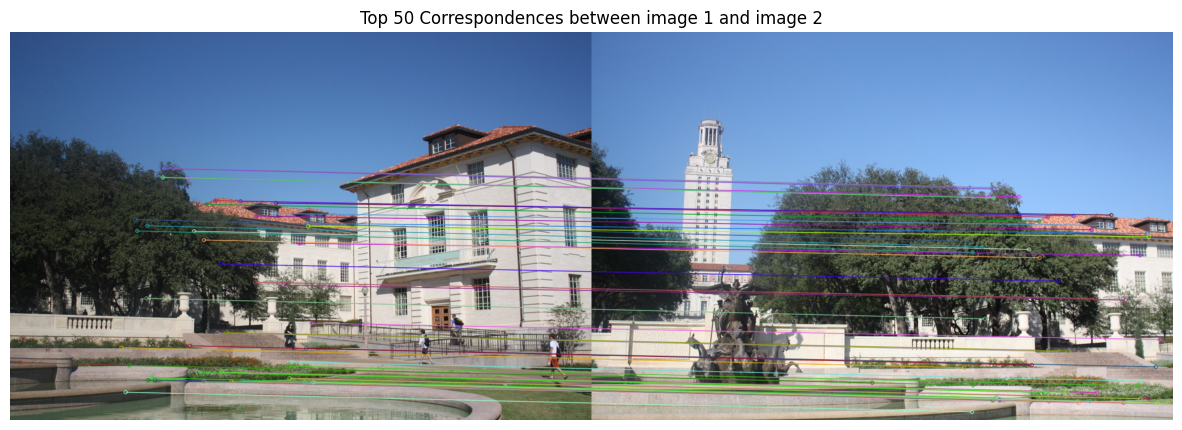

In [51]:
kp1, kp2, matches = plot_matches(img1, img2)

In [52]:
H, inliers = compute_H(kp1, kp2, matches)

H using our function:
[[ 7.51742385e-01  3.27673792e-02  4.48836886e+02]
 [-1.38340632e-01  9.02662104e-01  7.82371626e+01]
 [-2.19134226e-04 -3.93453763e-05  1.00000000e+00]]
H using built-in function:
[[ 7.52223417e-01  3.33630036e-02  4.48672713e+02]
 [-1.38275979e-01  9.03324745e-01  7.80905387e+01]
 [-2.18991458e-04 -3.87105780e-05  1.00000000e+00]]


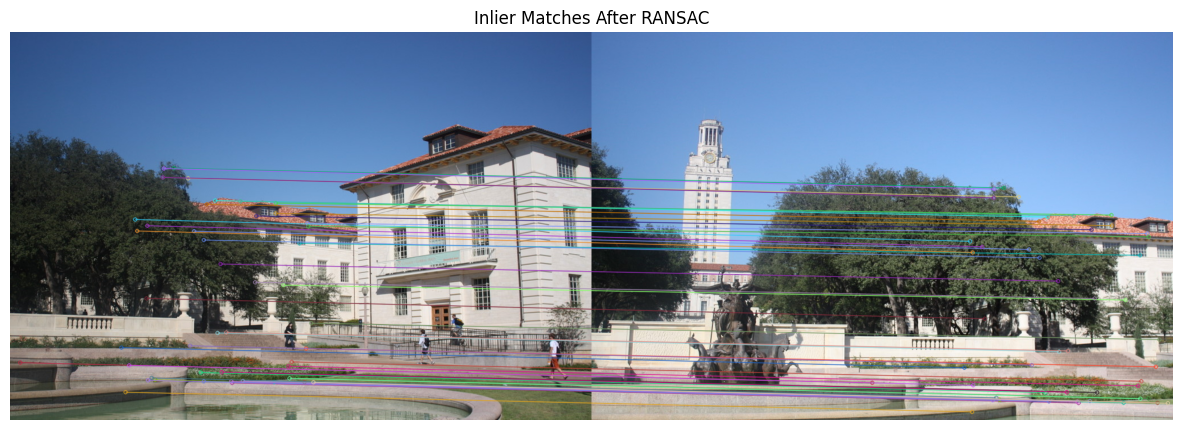

In [53]:
plot_inliers(inliers, kp1, kp2, img1, img2, matches)

<h3>2.2 Warping between planes</h3>

In [ ]:
# apply homography transformation to get corresponding point in destination image
def homography(xy_tuple, H):
    x, y = xy_tuple
    # homogeneous vector
    input_px = np.array(([x], [y], [1]))
    # H.P
    output_px = H.dot(input_px)
    # normalizaion
    output_px /= output_px[2]
    return output_px[0], output_px[1]
    

In [55]:
def delete_black(image):
    # Deleting black rows
    idy = np.argwhere(np.all(image[..., :] == 0, axis=1))
    image = np.delete(image, idy, axis=0)
    # Deleting black columns
    idx = np.argwhere(np.all(image[..., :] == 0, axis=0))
    image = np.delete(image, idx, axis=1)
    return image


In [56]:
def get_subpixels(img, x, y):
    h, w = img.shape[:2]
    # get the 4 surroinding pixels of the current pixel
    subpixels = [
    (int(np.floor(x).item()), int(np.floor(y).item())),
    (int(np.ceil(x).item()), int(np.floor(y).item())),
    (int(np.floor(x).item()), int(np.ceil(y).item())),
    (int(np.ceil(x).item()), int(np.ceil(y).item())),
]

    # Filter out-of-bounds pixels
    subpixels = [(sx, sy) for (sx, sy) in subpixels if 0 <= sx < w and 0 <= sy < h]
    return subpixels


In [57]:
def bilinear_interpolation(x, y, subpixels):
    subpixels = sorted(subpixels)
    (x1, y1, w11), (_x1, y2, w12), (x2, _y1, w21), (_x2, _y2, w22) = subpixels

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('Points do not form rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) out of bounds')

    return int(np.round((w11 * (x2 - x) * (y2 - y) +
            w21 * (x - x1) * (y2 - y) +
            w12 * (x2 - x) * (y - y1) +
            w22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1))))

In [58]:
def get_bounding_box(img, H):
    min_x = np.inf
    min_y = np.inf
    max_x = -np.inf
    max_y = -np.inf

    # dictionary to map each pixel to its warped position
    src_to_dest = dict()
    height, width = img.shape[:2]
    for y_src in range(height):
        for x_src in range(width):
            # apply homography for each pixel
            x_dest, y_dest = homography((x_src, y_src), H)
            src_to_dest[x_src, y_src] = (x_dest, y_dest)
            min_x = int(min(min_x, x_dest.item()))
            min_y = int(min(min_y, y_dest.item()))
            max_x = int(max(max_x, x_dest.item()))
            max_y = int(max(max_y, y_dest.item()))


    return min_x, min_y, max_x, max_y, src_to_dest

In [59]:
def warp_image(img, H):
    min_x, min_y, max_x, max_y, src_to_dest_map = get_bounding_box(img, H)
    bounding_box = ((min_x, min_y), (max_x, max_y))

    new_h = max_y - min_y + 1
    new_w = max_x - min_x + 1

    warped_image = np.zeros((new_h, new_w, 3), dtype=np.float32)
    accumulator = np.zeros((new_h, new_w, 3), dtype=np.float32)

    h, w = img.shape[:2]

    for x_src in range(w):
        for y_src in range(h):
            x_dest, y_dest = src_to_dest_map[(x_src, y_src)]
            x_dest -= min_x
            y_dest -= min_y

            subpixels = get_subpixels(warped_image, x_dest, y_dest)

            for (sx, sy) in subpixels:
                for ch in range(3):
                    warped_image[sy, sx, ch] += img[y_src, x_src, ch]
                    accumulator[sy, sx, ch] += 1

    
    mask = accumulator > 0
    warped_image[mask] = warped_image[mask] / accumulator[mask]

    return warped_image.astype(np.uint8), bounding_box


In [60]:
def inv_warp_image(img, img_warped, bounding_box, H):
    height, width = img.shape[:2]
    new_height, new_width = img_warped.shape[:2]
    inv_H = np.linalg.inv(H)
    (min_x, min_y), (max_x, max_y) = bounding_box
    for x_dest in range(new_width):
        for y_dest in range(new_height):
            if (img_warped[y_dest][x_dest] == [0,0,0]).all():
                x_src, y_src = homography((x_dest, y_dest), inv_H)
                x_src += min_x
                y_src += min_y
                if x_src >= 0 and x_src < width and y_src >= 0 and y_src < height:
                    for ch in range(3):
                        img_warped[y_dest][x_dest][ch] = bilinear_interpolation(x_src, 
                                                                                y_src, 
                                                                                get_subpixels(img[:,:,ch], x_src, y_src))
    return img_warped.astype(np.uint8)

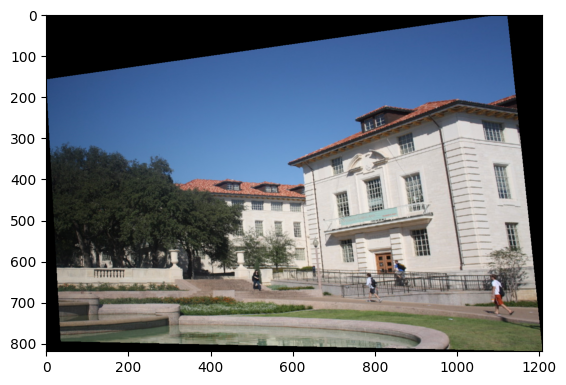

In [61]:
image1_warped, bounding_box = warp_image(img1, H)
plt.imshow(image1_warped)
plt.show()

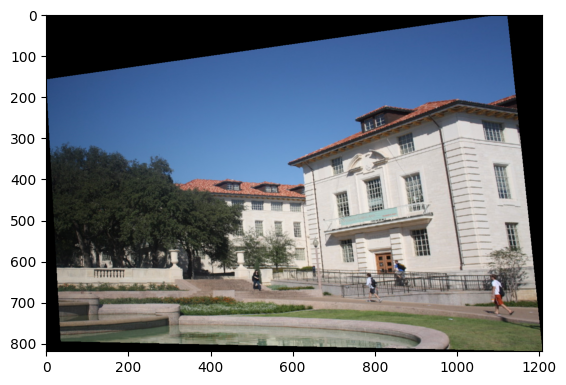

In [62]:
image_1_inv_warped = inv_warp_image(img1, image1_warped, bounding_box, H)
plt.imshow(image_1_inv_warped)

<h3>2.3 Output Mosaic

In [63]:
def stitch_images(image1_warped, image2, bounding_box):
    new_height, new_width = image1_warped.shape[:2]
    height2, width2 = image2.shape[:2]

    # distance that image 2 must be moved to be aligned with the warped image
    x_shift = -bounding_box[0][0]
    y_shift = -bounding_box[0][1]
    
    # black canvas to lay images on
    image_full = np.zeros(((new_height + height2), (new_width + width2), 3))

    # paste the warped image to the top left corner of the black canvas
    image_full[0:image1_warped.shape[0], 0:image1_warped.shape[1]] = image1_warped
    
    # shift each pixel in image 2 individually to align with the warped image
    for y in range(height2):
        for x in range(width2):
            x_new, y_new = x + x_shift , y + y_shift
            image_full[y_new][x_new] = image2[y][x]
    
    if x_shift < 0:
        image_full = np.roll(image_full, -x_shift, axis=1)
    if y_shift < 0:
        image_full = np.roll(image_full, -y_shift, axis=0)
    
    image_full = delete_black(image_full)
    
    return image_full.astype(np.uint8)


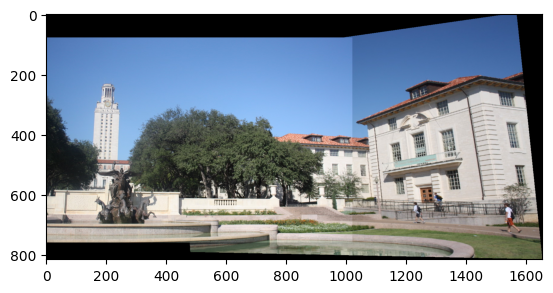

In [64]:
image_full = stitch_images(image1_warped, img2, bounding_box)
cv2.imwrite('../output/image_full.jpg', cv2.cvtColor(image_full, cv2.COLOR_RGB2BGR))
plt.imshow(image_full)

<h3>3 Bonus</h3>

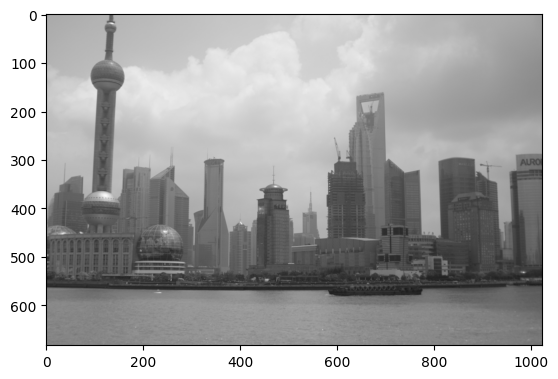

In [65]:
root = os.getcwd()

img_path_1 = os.path.join(root, '../material/shanghai-21.png')
img_path_2 = os.path.join(root, '../material/shanghai-22.png')
img_path_3 = os.path.join(root, '../material/shanghai-23.png')


image_1 = cv2.imread(img_path_1)
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)

image_2 = cv2.imread(img_path_2)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

image_3 = cv2.imread(img_path_3)
image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB)


plt.imshow(image_3)

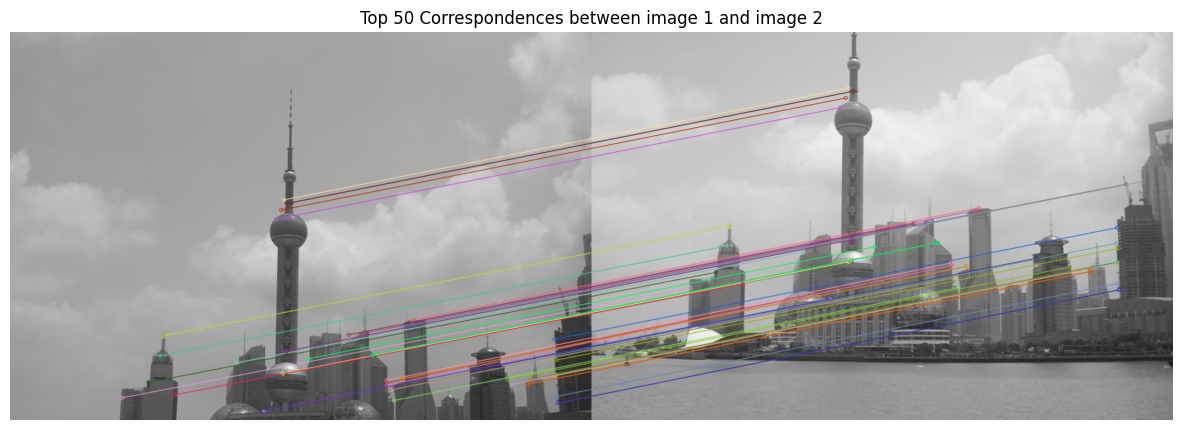

In [66]:
kp11, kp12, matches_1 = plot_matches(image_2, image_1)

In [67]:
H_1, inliers_1 = compute_H(kp11, kp12, matches_1)

H using our function:
[[ 1.04953871e+00  4.67450680e-02 -5.44251329e+01]
 [ 3.10510598e-05  1.06771015e+00 -2.14359470e+02]
 [ 1.17200494e-05  8.21821639e-05  1.00000000e+00]]
H using built-in function:
[[ 1.04038544e+00  4.05045407e-02 -5.00829895e+01]
 [-8.65297687e-04  1.05813350e+00 -2.11509408e+02]
 [ 1.06958750e-05  6.91070967e-05  1.00000000e+00]]


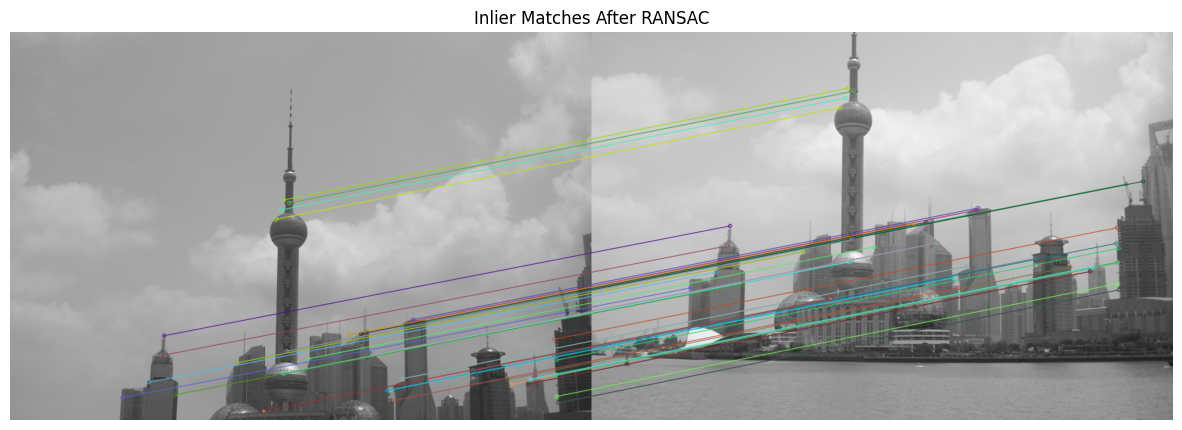

In [68]:
plot_inliers(inliers_1, kp11, kp12, image_2, image_1, matches_1)


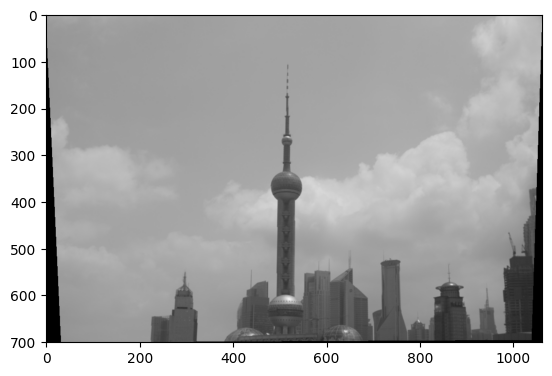

In [69]:
image_11_warped, bounding_box_11 = warp_image(image_2, H_1)
plt.imshow(image_11_warped)
plt.show()

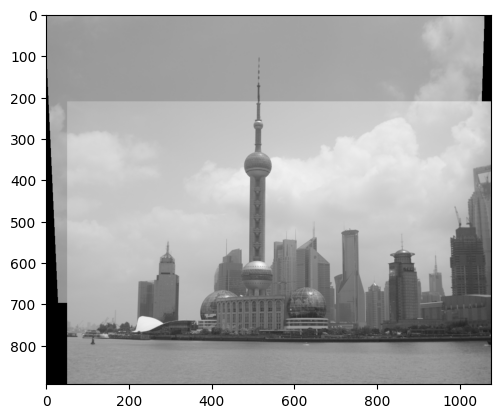

In [70]:
shanghai_stitched_11 = stitch_images(image_11_warped, image_1, bounding_box_11)
cv2.imwrite('../output/shanghai_stitched_11.png', cv2.cvtColor(shanghai_stitched_11, cv2.COLOR_RGB2BGR))
plt.imshow(shanghai_stitched_11)

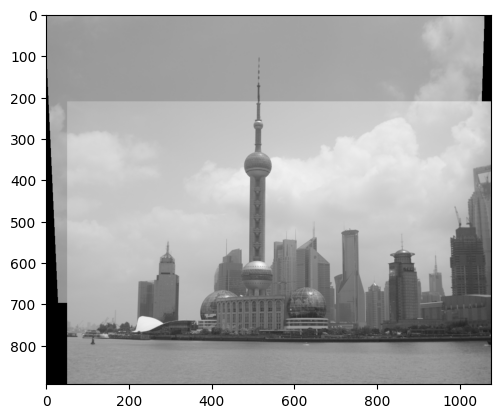

In [71]:
image_4_path = img_path_4 = os.path.join(root, '../output/shanghai_stitched_11.png')

image_4 = cv2.imread(image_4_path)

image_4 = cv2.cvtColor(image_4, cv2.COLOR_BGR2RGB)

plt.imshow(image_4)

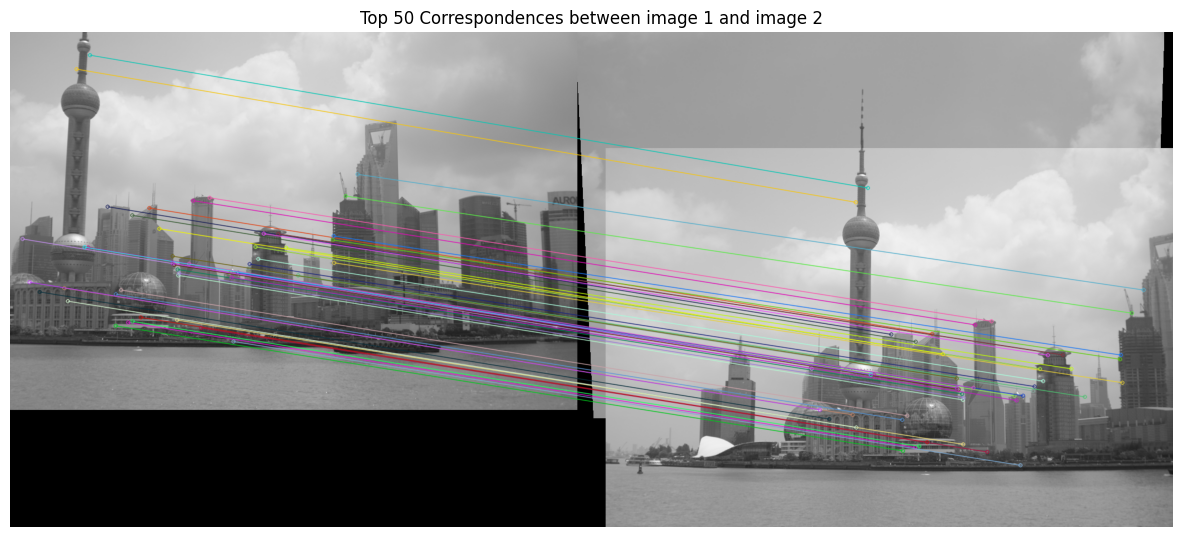

In [72]:
kp21, kp22, matches_2 = plot_matches(image_3, image_4)

In [73]:
H_2, inliers_2 = compute_H(kp21, kp22, matches_2)

H using our function:
[[ 8.78093157e-01  3.05039470e-02  3.88693082e+02]
 [-9.95212145e-02  9.50397151e-01  2.50526648e+02]
 [-1.12475435e-04 -9.93834019e-06  1.00000000e+00]]
H using built-in function:
[[ 8.79150319e-01  3.21352412e-02  3.88466682e+02]
 [-9.97090099e-02  9.52839905e-01  2.50393600e+02]
 [-1.12397594e-04 -7.28894562e-06  1.00000000e+00]]


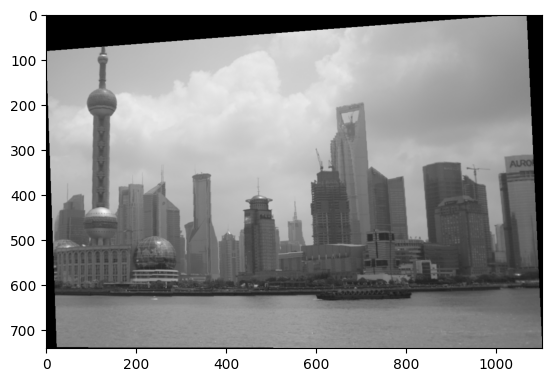

In [74]:
image_22_warped, bounding_box_22 = warp_image(image_3, H_2)
plt.imshow(image_22_warped)
plt.show()

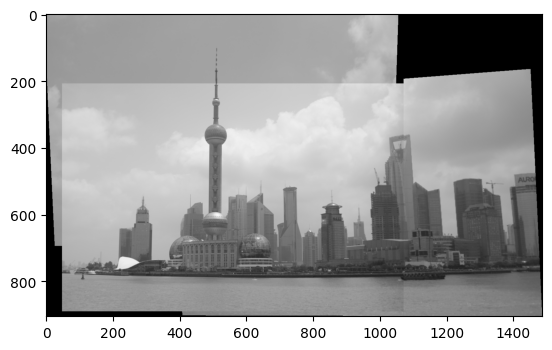

In [75]:
shanghai_full = stitch_images(image_22_warped, image_4, bounding_box_22)
cv2.imwrite('../output/shanghai_full.png', cv2.cvtColor(shanghai_full, cv2.COLOR_RGB2BGR))
plt.imshow(shanghai_full)